In [1]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)
library(glmnet)
library(glmnetUtils)

install.packages("pracma")
library("pracma")



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ──────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.3.1
✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ ggplot2 3.1.1     ✔ forcats 0.4.0
── Conflicts ─────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: Matrix

At

In [2]:
ATAC_pred <- readRDS(snakemake@input[["input_predictions"]])
#ATAC_pred <- readRDS("../data/ATAC_predictions_train_20_predict_80/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")

head(ATAC_pred)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_39,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,-0.405123632,0.59187320,-0.29125018,-0.58276010,0.3792968,-0.04366948,0.9183014,0.7664238,0.9980457,-1.0572778
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,-0.849313481,0.39431325,0.05197526,-0.36318168,0.1744439,-0.13785162,0.5392077,0.3942941,1.7972449,-0.3619464
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,-0.871941533,-0.06389996,-0.22907645,-0.32470631,-0.6251958,0.17051719,0.6882020,0.1744819,1.4357406,-0.2330366
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,-0.005893625,0.18185487,0.32387927,0.04577069,0.2752394,0.22750427,0.6333635,0.8413436,1.2819797,0.5629469
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,-0.067895629,-0.05197828,-0.18308631,-0.70242368,-0.4281903,-0.06235782,1.0764914,1.1411410,0.8795170,-0.4910720
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,-0.735310376,0.36325245,0.20814984,-0.50307962,0.2609116,0.53933999,1.0772367,0.6906960,1.7696570,-0.4181884


In [3]:
sample_types <- readRDS(snakemake@input[["input_sample_types"]])
#sample_types <- read.table(file = "../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [4]:
data <- merge(ATAC_pred, sample_types, by="sample")
#data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-0.34089350,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.17629217,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,1.22409122,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,0.43571295,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,0.04951928,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,0.50968208,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,Ovarian_Cancer


In [5]:
data %>% group_by(sample_type) %>% summarize(n = n())
data <-subset(data, sample_type != "Duodenal_Cancer")
data$sample_type <- as.factor(data$sample_type)
data <- data %>% droplevels("Duodenal_Cancer")
data %>% group_by(sample_type) %>% summarize(n = n())

sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Duodenal_Cancer,1
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


In [6]:
data <- data %>% select(-sample)
head(data)
dim(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type
0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,1.45146500,...,-0.34089350,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,Gastric_cancer
1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,0.04814456,...,-0.17629217,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,Gastric_cancer
0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,1.33462998,...,1.22409122,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,Gastric_cancer
1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,0.97671516,...,0.43571295,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,Gastric_cancer
0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,0.76308429,...,0.04951928,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,Ovarian_Cancer
0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,0.64706533,...,0.50968208,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,Ovarian_Cancer


[1]   423 10304

In [9]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

nested_CV_lasso <- function(data, k_inner_cv, k_outer_cv){
    
    y <- data %>% dplyr::select(sample_type) %>%  as.matrix()
    X <- data %>% dplyr::select(-sample_type) %>% as.matrix() 
    observed <- y
    return_tibble <- tibble()
    
    for (i in 1:k_outer_cv){ # repeated Cross-validation loop
    
        set.seed(i)
        cvfolds <- cut(1:nrow(data), breaks = k_inner_cv, labels = F)
        cvfolds <- sample(cvfolds)

        #predicted <- rep(NA, nrow(data))
        predicted <- tibble(CV_rep = rep(i, nrow(data)),
                            Bile_Duct_Cancer = rep(NA, nrow(data)),
                            Breast_Cancer = rep(NA, nrow(data)),
                            Colorectal_Cancer = rep(NA, nrow(data)),
                            Gastric_cancer = rep(NA, nrow(data)),
                            Healthy = rep(NA, nrow(data)),
                            Lung_Cancer = rep(NA, nrow(data)),
                            Ovarian_Cancer = rep(NA, nrow(data)),
                            Pancreatic_Cancer = rep(NA, nrow(data)))           

        for (n in 1:k_inner_cv){
            rows      <- which(cvfolds==n)
            testdata  <- X[rows,]
            traindata <- X[-rows,]
            train_y <- y[-rows,]

            ########### nested CV to find best alpha and lambda on train folds ###########
            set.seed(0) # alpha
            lasso_cva <- cva.glmnet(traindata, train_y, nfolds = 10, family = "multinomial")
            enet_performance <- data.frame(alpha = lasso_cva$alpha)
            models <- lasso_cva$modlist
            enet_performance$cvm <- vapply(models, get_cvm, numeric(1))
            minix <- which.min(enet_performance$cvm)
            best_alpha <- lasso_cva$alpha[minix]

            set.seed(0) # lambda
            lasso_cv <- cv.glmnet(traindata, 
                                  train_y, 
                                  alpha = best_alpha, 
                                  standardize = TRUE, 
                                  nfolds = 10, 
                                  family = "multinomial")
            message(plot(lasso_cv))
            lambda_cv <- lasso_cv$lambda.min
            
            message("best_alpha")
            message(best_alpha)
            message("best_lambda")
            message(lambda_cv)
            ####################################################################

            fit       <- glmnet(traindata, train_y, family = "multinomial", alpha = best_alpha, lambda = lambda_cv)
            tmp       <- predict(fit, s=lambda_cv, testdata, type = "response")

            
            tmp <- as.data.frame(tmp[, , ], row.names = NULL)
            #IRdisplay::display(tmp)
            #message(str(tmp))
            predicted[rows, 2:9] <- as.data.frame(tmp)
        }
        
    #current_round_tibble <- tibble(predicted = predicted)
    #IRdisplay::display(return_tibble)
    
    current_round_tibble <- predicted
    return_tibble <- rbind(return_tibble, current_round_tibble)
    } # end of outer cv loop
    
    add_observed <- tibble(observed = rep(pull(data, sample_type), k_outer_cv))
    #dim(add_observed)
    return_tibble <- cbind(add_observed, return_tibble)
    return(return_tibble)
}

Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous groun

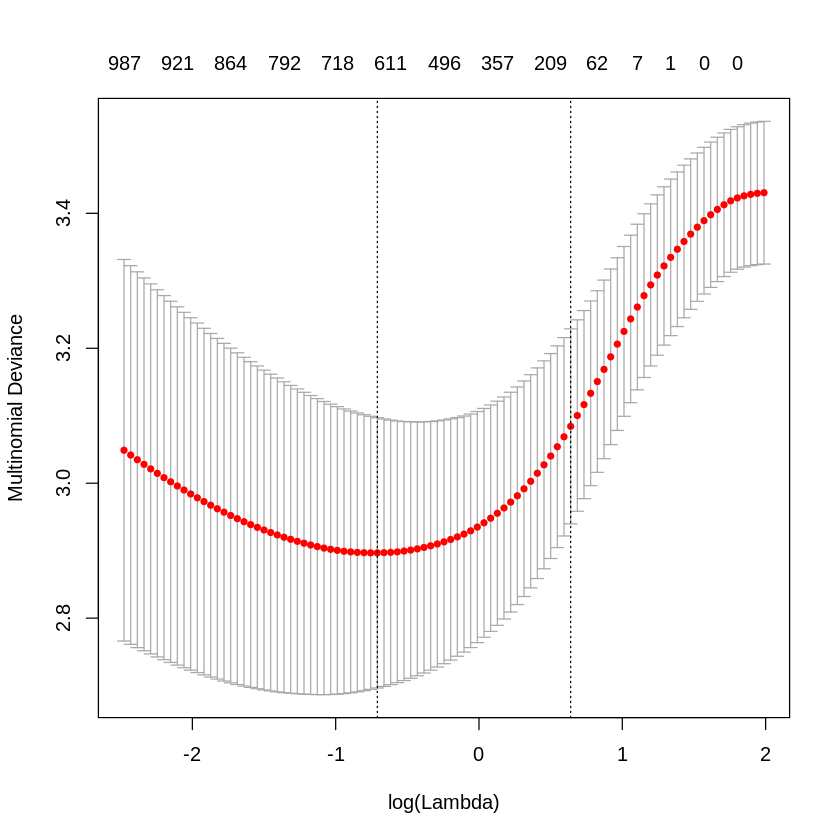


best_alpha
0.008
best_lambda
1.64457694684393
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class 

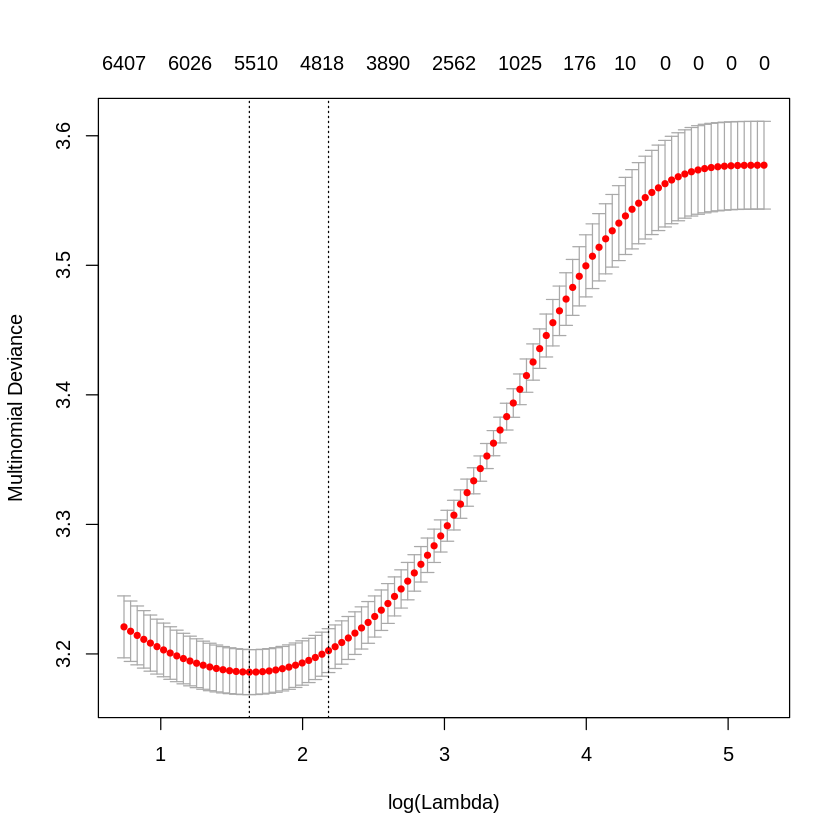


best_alpha
0.008
best_lambda
1.30402312486396


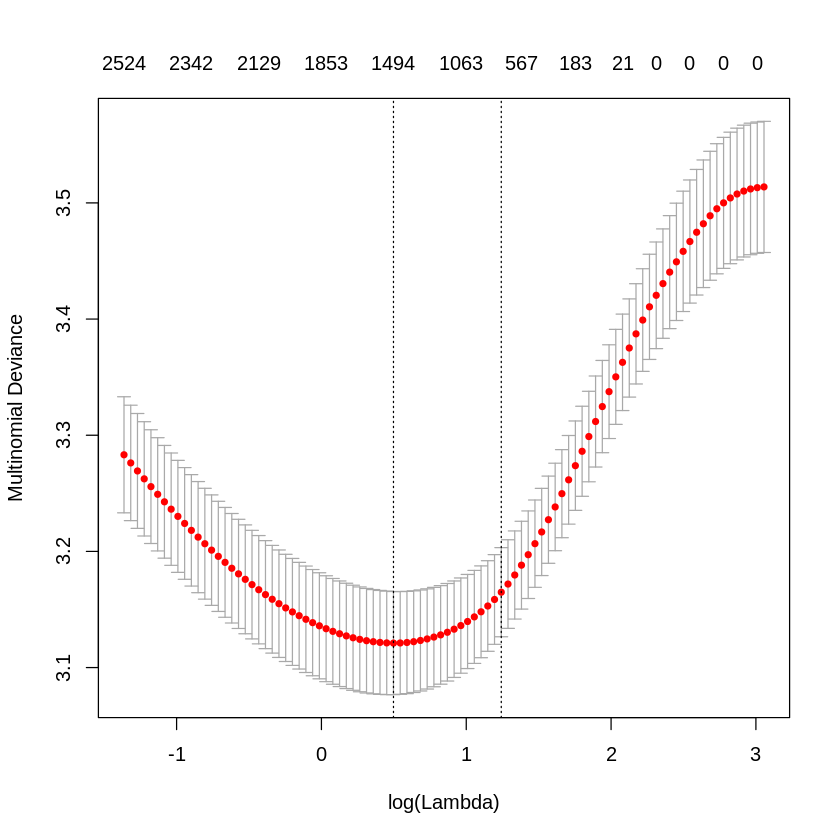

observed,CV_rep,Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer
Gastric_cancer,1,0.04718158,0.10697340,0.04453785,0.048496507,0.60942963,0.059225260,0.04863618,0.03551958
Gastric_cancer,1,0.03344863,0.07909109,0.03094948,0.051950715,0.65987669,0.050531361,0.04760928,0.04654275
Gastric_cancer,1,0.12922800,0.01254526,0.02081142,0.005730668,0.02064537,0.008305593,0.07728746,0.72544623
Gastric_cancer,1,0.01332141,0.07014509,0.02701248,0.023368677,0.77119613,0.054273427,0.02150422,0.01917856
Ovarian_Cancer,1,0.04086668,0.08917293,0.05720628,0.050837951,0.57307433,0.093580092,0.05548205,0.03977970
Ovarian_Cancer,1,0.11469952,0.11646053,0.08281647,0.077157007,0.32671199,0.092244475,0.07777522,0.11213479


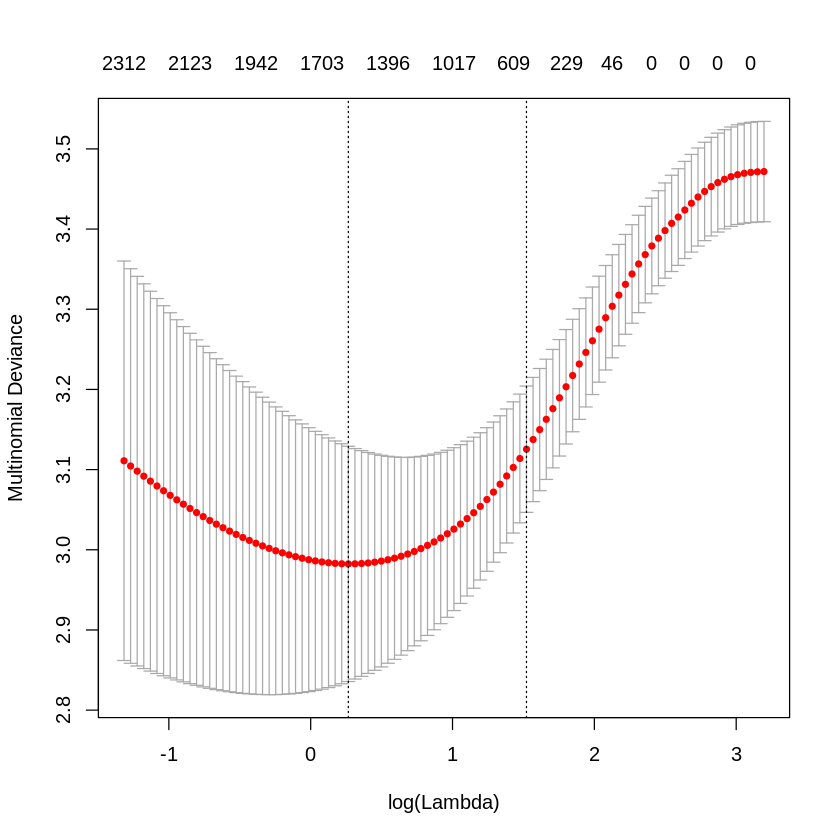

In [10]:
k_outer_cv = 10
results <- nested_CV_lasso(data, k_inner_cv = 10, k_outer_cv = k_outer_cv)
head(results)

In [ ]:
saveRDS(results, file = snakemake@output[["lasso_output"]])

## AUC calculation with pROC package == One vs. one

In [12]:
rocs <- list()
list_names <- paste0("CV_rep_", 1:k_outer_cv)
for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i) %>% select(-c(CV_rep, observed))
    roc <- multiclass.roc(response = data$sample_type, predictor = res_CV)
    rocs[[i]] <- roc
}
names(rocs) <- c(list_names)

paste0("The AUC of the first CV repetition: ", rocs[[1]]$auc)

aucs <- c()
for (i in 1:length(rocs)){
    aucs <- c(aucs, rocs[[i]]$auc) 
}

paste0("The mean AUC of all the CV repetitions: ", mean(aucs))

[1] "The AUC of the first CV repetition: 0.706167017645092"

[1] "The mean AUC of all the CV repetitions: 0.713295868895109"

## AUC calculation with functions == One vs. one (source: https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/)

In [13]:
# run only for the first CV repetition to check that we get the same number

res_CV <- data.frame(results %>% filter(CV_rep == 1) %>% select(-c(CV_rep, observed)))
head(res_CV)

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer
0.04718158,0.10697340,0.04453785,0.048496507,0.60942963,0.059225260,0.04863618,0.03551958
0.03344863,0.07909109,0.03094948,0.051950715,0.65987669,0.050531361,0.04760928,0.04654275
0.12922800,0.01254526,0.02081142,0.005730668,0.02064537,0.008305593,0.07728746,0.72544623
0.01332141,0.07014509,0.02701248,0.023368677,0.77119613,0.054273427,0.02150422,0.01917856
0.04086668,0.08917293,0.05720628,0.050837951,0.57307433,0.093580092,0.05548205,0.03977970
0.11469952,0.11646053,0.08281647,0.077157007,0.32671199,0.092244475,0.07777522,0.11213479


In [14]:
compute.A.conditional <- function(pred.matrix, i, j, ref.outcome) {
    # computes A(i|j), the probability that a randomly 
    # chosen member of class j has a lower estimated probability (or score) 
    # of belonging to class i than a randomly chosen member of class i

    # select predictions of class members
    i.idx <- which(ref.outcome == i)
    j.idx <- which(ref.outcome == j)
    pred.i <- pred.matrix[i.idx, i] # p(G = i) assigned to class i observations
    pred.j <- pred.matrix[j.idx, i] # p(G = i) assigned to class j observations
    all.preds <- c(pred.i, pred.j)
    classes <- c(rep(i, length(pred.i)), rep(j, length(pred.j)))
    o <- order(all.preds)
    classes.o <- classes[o]
    # Si: sum of ranks from class i observations
    Si <- sum(which(classes.o == i))
    ni <- length(i.idx)
    nj <- length(j.idx)
    # calculate A(i|j)
    A <- (Si - ((ni * (ni + 1))/2)) / (ni * nj)
    return(A)
}

multiclass.auc <- function(pred.matrix, ref.outcome) {
    labels <- colnames(pred.matrix)
    A.ij.cond <- utils::combn(labels, 2, function(x, pred.matrix, ref.outcome) {x
        i <- x[1]
        j <- x[2]
        A.ij <- compute.A.conditional(pred.matrix, i, j, ref.outcome)
        A.ji <- compute.A.conditional(pred.matrix, j, i, ref.outcome)
        pair <- paste0(i, "/", j)
        return(c(A.ij, A.ji))
    }, simplify = FALSE, pred.matrix = pred.matrix, ref.outcome = ref.outcome)
    c <- length(labels)
    pairs <- unlist(lapply(combn(labels, 2, simplify = FALSE), function(x) paste(x, collapse = "/")))
    A.mean <- unlist(lapply(A.ij.cond, mean))
    names(A.mean) <- pairs
    A.ij.joint <- sum(unlist(A.mean))
    M <- 2 / (c * (c-1)) * A.ij.joint 
    attr(M, "pair_AUCs") <- A.mean
    return(M)
}                          
M <- multiclass.auc(res_CV, data$sample_type)
print(paste0("Generalized AUC is: ", round(as.numeric(M), 3)))
                           
print(attr(M, "pair_AUCs"))

[1] "Generalized AUC is: 0.706"
     Bile_Duct_Cancer/Breast_Cancer  Bile_Duct_Cancer/Colorectal_Cancer 
                          0.8181481                           0.6392308 
    Bile_Duct_Cancer/Gastric_cancer            Bile_Duct_Cancer/Healthy 
                          0.6022222                           0.8844330 
       Bile_Duct_Cancer/Lung_Cancer     Bile_Duct_Cancer/Ovarian_Cancer 
                          0.8022857                           0.6135714 
 Bile_Duct_Cancer/Pancreatic_Cancer     Breast_Cancer/Colorectal_Cancer 
                          0.4794118                           0.8087607 
       Breast_Cancer/Gastric_cancer               Breast_Cancer/Healthy 
                          0.7074760                           0.8735682 
          Breast_Cancer/Lung_Cancer        Breast_Cancer/Ovarian_Cancer 
                          0.7042328                           0.6335979 
    Breast_Cancer/Pancreatic_Cancer    Colorectal_Cancer/Gastric_cancer 
                   

## AUC calculation with HandTill2001 package == One vs. one (original paper of the approach: https://link.springer.com/content/pdf/10.1023/A:1010920819831.pdf)

In [15]:
if (! require("remotes")) install.packages("remotes")
remotes::install_gitlab("fvafrCU/HandTill2001")

library(HandTill2001)

# run only for the first CV repetition to check that we get the same number

paste0("The AUC of the first CV repetition: ", auc(multcap(response = data$sample_type, predicted = as.matrix(res_CV))))


Loading required package: remotes
Skipping install of 'HandTill2001' from a gitlab remote, the SHA1 (90deae92) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘HandTill2001’

The following object is masked from ‘package:glmnet’:

    auc

The following object is masked from ‘package:pROC’:

    auc



[1] "The AUC of the first CV repetition: 0.706167017645092"

# AUC calculation with multiROC package == One vs. rest, and plotting (https://github.com/WandeRum/multiROC)

In [16]:
install.packages('multiROC')
library(multiROC)

install.packages('dummies')
library(dummies)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
dummies-1.5.6 provided by Decision Patterns



### Example of the calculations and plotting wiht the first CV repetition

In [17]:
# prep the data frame

colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

true_label <- dummies::dummy(data$sample_type, sep = ".")
true_label <- data.frame(true_label)
colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
final_df <- cbind(true_label, res_CV)

head(final_df)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

Bile_Duct_Cancer_true,Breast_Cancer_true,Colorectal_Cancer_true,Gastric_cancer_true,Healthy_true,Lung_Cancer_true,Ovarian_Cancer_true,Pancreatic_Cancer_true,Bile_Duct_Cancer_pred_lasso,Breast_Cancer_pred_lasso,Colorectal_Cancer_pred_lasso,Gastric_cancer_pred_lasso,Healthy_pred_lasso,Lung_Cancer_pred_lasso,Ovarian_Cancer_pred_lasso,Pancreatic_Cancer_pred_lasso
0,0,0,1,0,0,0,0,0.04718158,0.10697340,0.04453785,0.048496507,0.60942963,0.059225260,0.04863618,0.03551958
0,0,0,1,0,0,0,0,0.03344863,0.07909109,0.03094948,0.051950715,0.65987669,0.050531361,0.04760928,0.04654275
0,0,0,1,0,0,0,0,0.12922800,0.01254526,0.02081142,0.005730668,0.02064537,0.008305593,0.07728746,0.72544623
0,0,0,1,0,0,0,0,0.01332141,0.07014509,0.02701248,0.023368677,0.77119613,0.054273427,0.02150422,0.01917856
0,0,0,0,0,0,1,0,0.04086668,0.08917293,0.05720628,0.050837951,0.57307433,0.093580092,0.05548205,0.03977970
0,0,0,0,0,0,1,0,0.11469952,0.11646053,0.08281647,0.077157007,0.32671199,0.092244475,0.07777522,0.11213479


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

Specificity,Sensitivity,Group,AUC,Method
1.0000000,0,Bile_Duct_Cancer,0.7932663,lasso
0.9974874,0,Bile_Duct_Cancer,0.7932663,lasso
0.9949749,0,Bile_Duct_Cancer,0.7932663,lasso
0.9924623,0,Bile_Duct_Cancer,0.7932663,lasso
0.9899497,0,Bile_Duct_Cancer,0.7932663,lasso
0.9874372,0,Bile_Duct_Cancer,0.7932663,lasso


[1] 9720    5

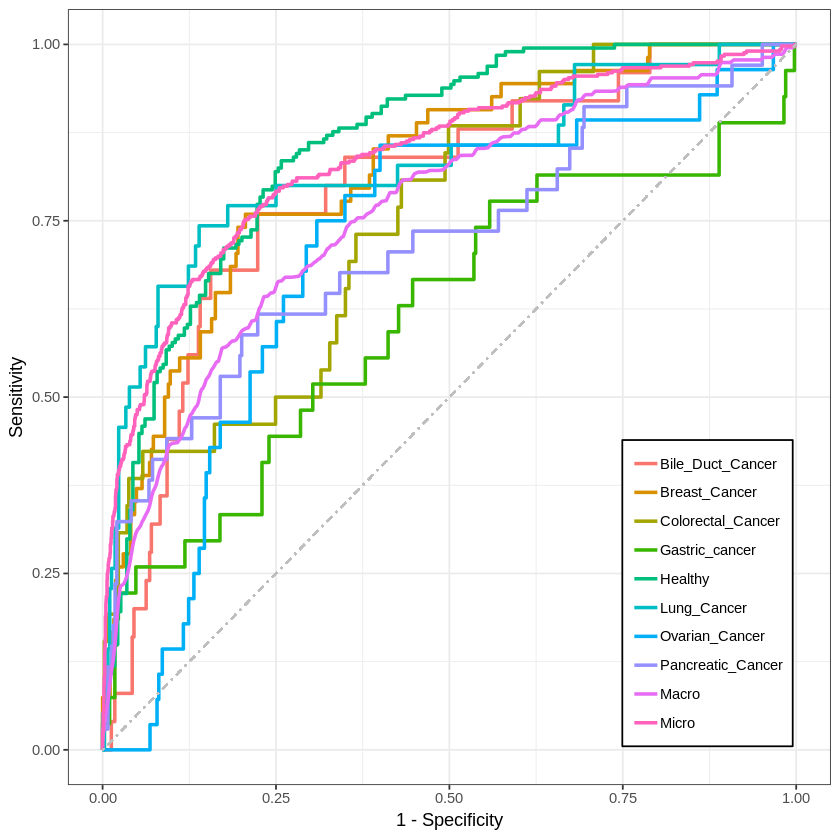

In [19]:
#perform multiroc and plot

roc_res <- multi_roc(final_df, force_diag=T)
plot_roc_df <- plot_roc_data(roc_res)
head(plot_roc_df)
dim(plot_roc_df)

ggplot(plot_roc_df, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))


In [20]:
# print AUCs
(AUCs <-roc_res$AUC %>%
  transpose() %>%
  as_tibble())

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer,macro,micro
0.7932663,0.8193315,0.7514048,0.615694,0.8574258,0.8293814,0.7075045,0.7192651,0.7616406,0.8384076


## Run the multiROC and plotting for all the CV repetitions

In [76]:
Specificities <- NULL
Sensitivities <- NULL

for (i in 1:k_outer_cv){
    res_CV <- data.frame(results %>% filter(CV_rep == i) %>% select(-c(CV_rep, observed)))
    
    colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

    true_label <- dummies::dummy(data$sample_type, sep = ".")
    true_label <- data.frame(true_label)
    colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
    colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
    final_df <- cbind(true_label, res_CV)

    roc_res <- multi_roc(final_df, force_diag=T)
    
    if (i == 1){
        AUCs <- as.data.frame(t(unlist(roc_res$AUC)))
    }
    else {
        AUCs <- rbind(AUCs, as.data.frame(t(unlist(roc_res$AUC))))
    }
    
    plot_roc_df <- plot_roc_data(roc_res)
    plot_roc_df <- plot_roc_df %>% select(-Method)
    
    if (i == 1){
        Specificities <- plot_roc_df %>% select(Specificity)
        Sensitivities <- plot_roc_df %>% select(Sensitivity)
        Groups  <- plot_roc_df %>% select(Group)
    }
    else {
        Specificities <- cbind(Specificities, plot_roc_df %>% select(Specificity))
        Sensitivities <- cbind(Sensitivities, plot_roc_df %>% select(Sensitivity))
    }
    
    #IRdisplay::display(all_plot_roc_df)

}
Specificities <- tibble(Specificities, .name_repair = "unique")
Specificities <- Specificities %>% mutate(mean = rowMeans(across()))
Sensitivities <- tibble(Sensitivities, .name_repair = "unique")
Sensitivities <- Sensitivities %>% mutate(mean = rowMeans(across()))

(AUCs <- tibble(AUCs))

all_sensitivity_specificity <- tibble(Specificity = Specificities$mean, Sensitivity = Sensitivities$mean, Group = Groups$Group)
head(all_sensitivity_specificity)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“

lasso.Bile_Duct_Cancer,lasso.Breast_Cancer,lasso.Colorectal_Cancer,lasso.Gastric_cancer,lasso.Healthy,lasso.Lung_Cancer,lasso.Ovarian_Cancer,lasso.Pancreatic_Cancer,lasso.macro,lasso.micro
0.7932663,0.8193315,0.7514048,0.6156940,0.8574258,0.8293814,0.7075045,0.7192651,0.7616406,0.8384076
0.8557789,0.8263575,0.7921914,0.6921998,0.8513483,0.7743004,0.7448463,0.6734462,0.7762843,0.8422742


Specificity,Sensitivity,Group
1.0000000,0,Bile_Duct_Cancer
0.9974874,0,Bile_Duct_Cancer
0.9949749,0,Bile_Duct_Cancer
0.9924623,0,Bile_Duct_Cancer
0.9899497,0,Bile_Duct_Cancer
0.9874372,0,Bile_Duct_Cancer


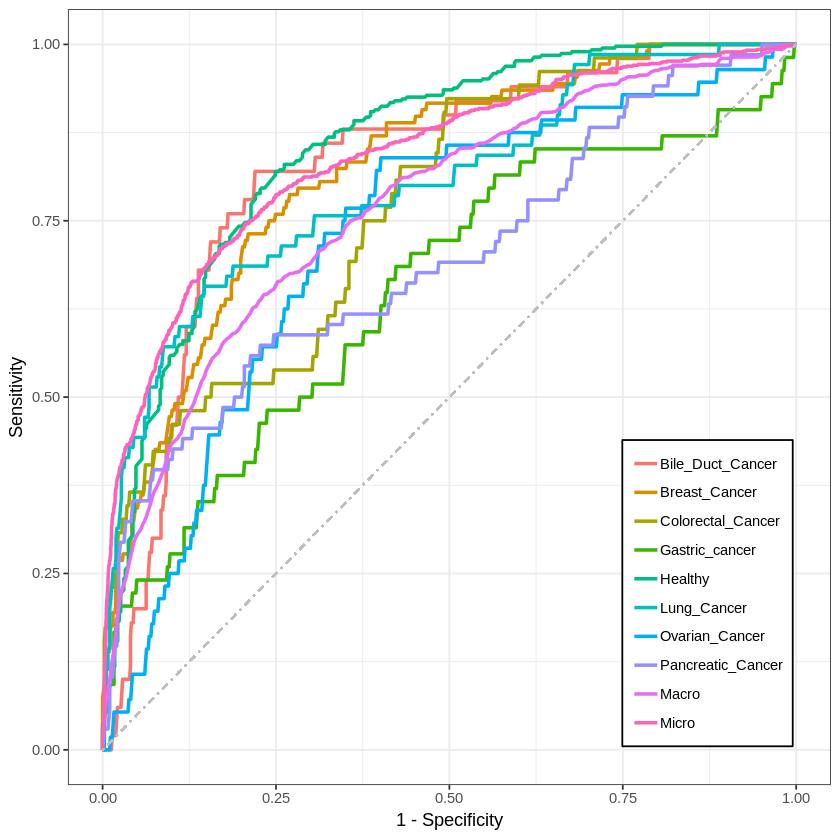

In [40]:
ggplot(all_sensitivity_specificity, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))

In [47]:
print("Mean AUC over 10 repetitions of 10-fold CV: ")
(mean_AUCs <- colMeans(AUCs[sapply(AUCs, is.numeric)]))

[1] "Mean AUC over 10 repetitions of 10-fold CV: "


lasso.Bile_Duct_Cancer     lasso.Breast_Cancer lasso.Colorectal_Cancer 
              0.8245226               0.8228445               0.7717981 
   lasso.Gastric_cancer           lasso.Healthy       lasso.Lung_Cancer 
              0.6539469               0.8543871               0.8018409 
   lasso.Ovarian_Cancer lasso.Pancreatic_Cancer             lasso.macro 
              0.7261754               0.6963557               0.7689625 
            lasso.micro 
              0.8403409

In [71]:
results01 <- tibble()

for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i)
    obs_rep <- res_CV %>% select(c(CV_rep, observed))
    res_CV <- res_CV %>% select(-c(CV_rep, observed))
    res_CV <- res_CV %>% mutate(pred01 = factor(colnames(res_CV)[apply(res_CV,1,which.max)], ordered = TRUE))
    res_CV <- cbind(res_CV, obs_rep)
    results01 <- rbind(results01, res_CV)
}

head(results01)

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer,pred01,CV_rep,observed
0.04718158,0.10697340,0.04453785,0.048496507,0.60942963,0.059225260,0.04863618,0.03551958,Healthy,1,Gastric_cancer
0.03344863,0.07909109,0.03094948,0.051950715,0.65987669,0.050531361,0.04760928,0.04654275,Healthy,1,Gastric_cancer
0.12922800,0.01254526,0.02081142,0.005730668,0.02064537,0.008305593,0.07728746,0.72544623,Pancreatic_Cancer,1,Gastric_cancer
0.01332141,0.07014509,0.02701248,0.023368677,0.77119613,0.054273427,0.02150422,0.01917856,Healthy,1,Gastric_cancer
0.04086668,0.08917293,0.05720628,0.050837951,0.57307433,0.093580092,0.05548205,0.03977970,Healthy,1,Ovarian_Cancer
0.11469952,0.11646053,0.08281647,0.077157007,0.32671199,0.092244475,0.07777522,0.11213479,Healthy,1,Ovarian_Cancer


In [79]:
error_rates <- c()
accuracies <- c()
for (i in 1:k_outer_cv){
    res_CV <- results01 %>% filter(CV_rep == i)
    error_rates <- c(error_rates, mean(as.character(res_CV$observed) != as.character(res_CV$pred01)))
    accuracies <- c(accuracies, mean(as.character(res_CV$observed) == as.character(res_CV$pred01)))
}

error_rates
accuracies

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.4869976 0.4869976

[1] 0.5130024 0.5130024

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.486997635933806"

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.513002364066194"